# Visual Sentimental Analysis

> by Seth, Ashwin, Jessie and Jed
>
> BuildingBloCS 2023 June Conference
>
> Intermediate Track
>
> "Intro to Deep Learning" Workshop

## Set-Up and Imports

Before we start, we have to install the dataset we are using. We are using a miniaturized form of a dataset known as the [Facial Expression Recognition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) dataset, which consists of `48x48` pixel grayscale images of faces. We aim to categorise each face into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

However, to conserve you some training time 🙃, we have adapted this dataset for a binary classification task where all you need to do is categorise each image into one of two categories (0=Sad, 1=Happy).

In [1]:
!curl -L "https://github.com/buildingblocs/intro-to-dl/raw/main/data.zip" -o data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  2  9.8M    2  223k    0     0  77193      0  0:02:13  0:00:02  0:02:11  239k
 48  9.8M   48 4863k    0     0  1207k      0  0:00:08  0:00:04  0:00:04 2439k
100  9.8M  100  9.8M    0     0  2063k      0  0:00:04  0:00:04 --:--:-- 3548k


In [2]:
!unzip -q data.zip
!ls data/images/

0
1


In this tutorial, we will use TensorFlow Keras to train our model. TensorFlow Keras is an industry standard Deep Learning Library, used by many major products.

In [3]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import cv2

import tensorflow as tf
from tensorflow.keras import layers

print(f"System version: {sys.version}")
print(f"OpenCV version: {cv2.__version__}")
print(f"Tensorflow version: {tf.__version__}")


# ignore this function for now
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].plot(acc, label='Training Accuracy')
    axes[0].plot(val_acc, label='Validation Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Training and Validation Accuracy')

    axes[1].plot(loss, label='Training Loss')
    axes[1].plot(val_loss, label='Validation Loss')
    axes[1].legend(loc='upper right')
    axes[1].set_ylabel('Cross Entropy')
    axes[1].set_title('Training and Validation Loss')
    axes[1].set_xlabel('epoch')
    
    plt.show()

System version: 3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]
OpenCV version: 4.7.0
Tensorflow version: 2.12.0


### Prepare the data

Let's use 80% of the data for model training and 20% for model validation.

In [4]:
val_size = 0.2  # @param
batch_size = 32  # @param
img_height = 48  # @param
img_width = 48  # @param

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "data/images",
  validation_split=val_size,
  subset="training",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "data/images",
  validation_split=val_size,
  subset="validation",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

# optimize data loading for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 9660 files belonging to 2 classes.
Using 7728 files for training.
Found 9660 files belonging to 2 classes.
Using 1932 files for validation.


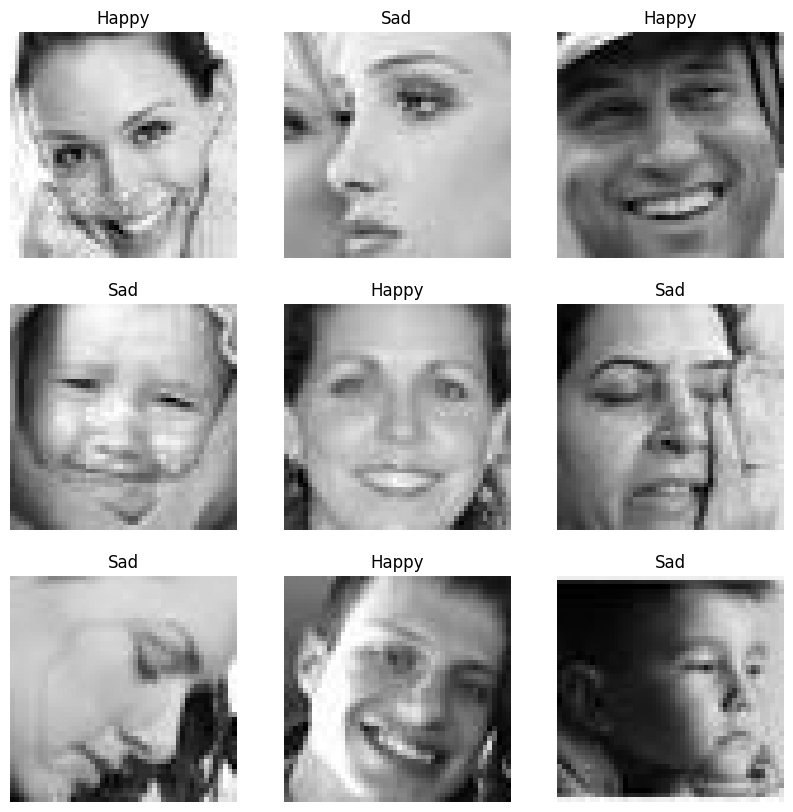

In [5]:
class_names = ['Sad', "Happy"]

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8").reshape(48, 48), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Deep Neural Networks - Multilayer Perceptrons (MLPs)

In [6]:
hidden_units = 128  # @param
dropout_rate = 0.2  # @param
learning_rate = 1e-4  # @param

mlp_model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_height, img_width, 1)),
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),
  layers.Flatten(),
  layers.Dense(hidden_units, activation='relu'),
  layers.Dropout(rate=dropout_rate),
  layers.Dense(hidden_units, activation='relu'),
  layers.Dense(2)
], name="MLP")

mlp_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

mlp_model.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 48, 48, 1)         0         
                                                                 
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               295040    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 2)                 258     

In [7]:
history = mlp_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
);

Epoch 1/20
242/242 [==============================] - 22s 83ms/step - loss: 0.6408 - accuracy: 0.6330 - val_loss: 0.5955 - val_accuracy: 0.6941
Epoch 2/20
242/242 [==============================] - 3s 13ms/step - loss: 0.5817 - accuracy: 0.6915 - val_loss: 0.5637 - val_accuracy: 0.7195
Epoch 3/20
242/242 [==============================] - 2s 10ms/step - loss: 0.5614 - accuracy: 0.7126 - val_loss: 0.5567 - val_accuracy: 0.7257
Epoch 4/20
242/242 [==============================] - 3s 10ms/step - loss: 0.5434 - accuracy: 0.7201 - val_loss: 0.5462 - val_accuracy: 0.7340
Epoch 5/20
242/242 [==============================] - 2s 10ms/step - loss: 0.5240 - accuracy: 0.7343 - val_loss: 0.5412 - val_accuracy: 0.7283
Epoch 6/20
242/242 [==============================] - 3s 12ms/step - loss: 0.5158 - accuracy: 0.7442 - val_loss: 0.5284 - val_accuracy: 0.7438
Epoch 7/20
242/242 [==============================] - 3s 12ms/step - loss: 0.5035 - accuracy: 0.7519 - val_loss: 0.5269 - val_accuracy: 0.738

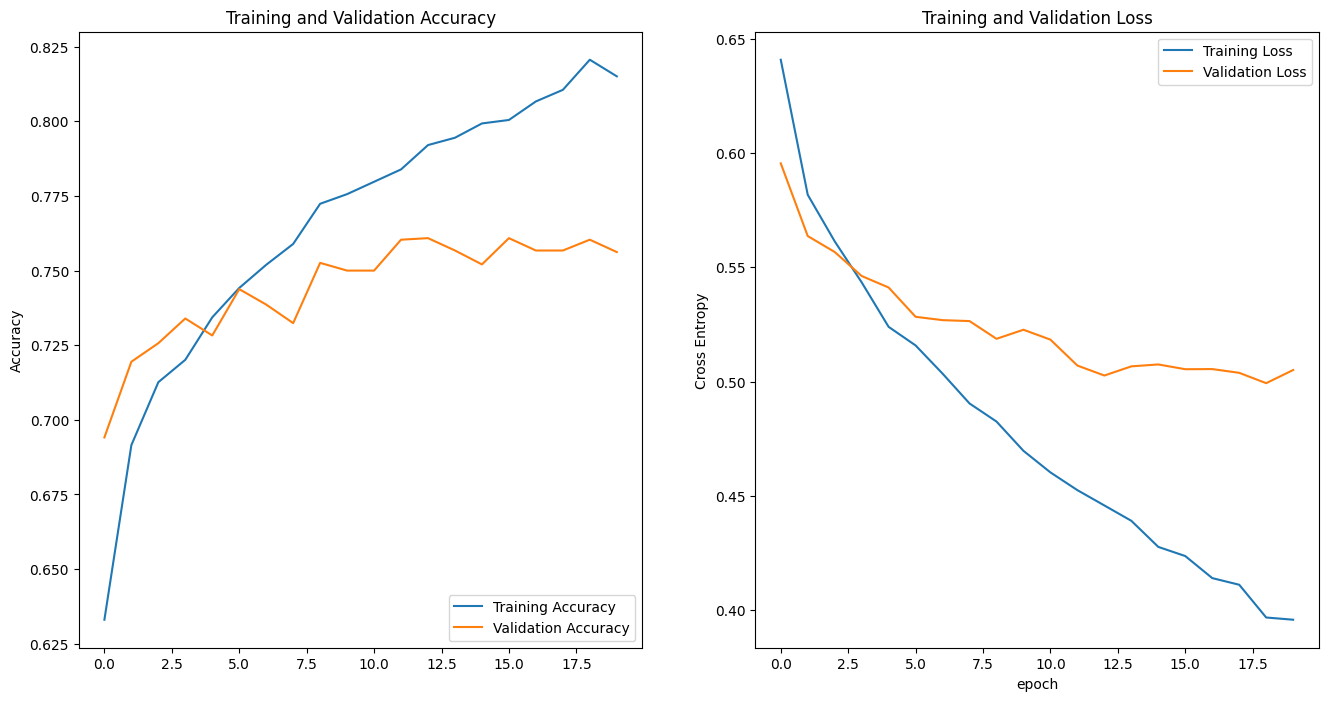

In [8]:
plot_history(history)

## Deep Convolutional Neural Networks

In [9]:
filters = 32  # @param
kernel_size = [3, 3]  # @param
strides = 1 # @param
hidden_units = 128  # @param
dropout_rate = 0.2  # @param
learning_rate = 1e-4 # @param

shallow_cnn_model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_height, img_width, 1)),
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),  
  layers.Conv2D(filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Flatten(),
  layers.Dropout(rate=dropout_rate),
  layers.Dense(hidden_units, activation='relu'),
  layers.Dense(2)
], name="Shallow-CNN")

shallow_cnn_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

shallow_cnn_model.summary()

Model: "Shallow-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 48, 48, 1)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_1 (Dropout)         (None, 18432)             0         
                                                       

In [10]:
history = shallow_cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
242/242 [==============================] - 25s 95ms/step - loss: 0.6268 - accuracy: 0.6542 - val_loss: 0.5654 - val_accuracy: 0.7246
Epoch 2/20
242/242 [==============================] - 25s 102ms/step - loss: 0.5622 - accuracy: 0.7109 - val_loss: 0.5393 - val_accuracy: 0.7448
Epoch 3/20
242/242 [==============================] - 28s 116ms/step - loss: 0.5313 - accuracy: 0.7324 - val_loss: 0.5217 - val_accuracy: 0.7500
Epoch 4/20
242/242 [==============================] - 14s 59ms/step - loss: 0.5114 - accuracy: 0.7465 - val_loss: 0.5103 - val_accuracy: 0.7536
Epoch 5/20
242/242 [==============================] - 21s 87ms/step - loss: 0.4908 - accuracy: 0.7575 - val_loss: 0.5018 - val_accuracy: 0.7516
Epoch 6/20
242/242 [==============================] - 29s 119ms/step - loss: 0.4772 - accuracy: 0.7704 - val_loss: 0.4988 - val_accuracy: 0.7583
Epoch 7/20
242/242 [==============================] - 28s 115ms/step - loss: 0.4625 - accuracy: 0.7773 - val_loss: 0.4892 - val_accur

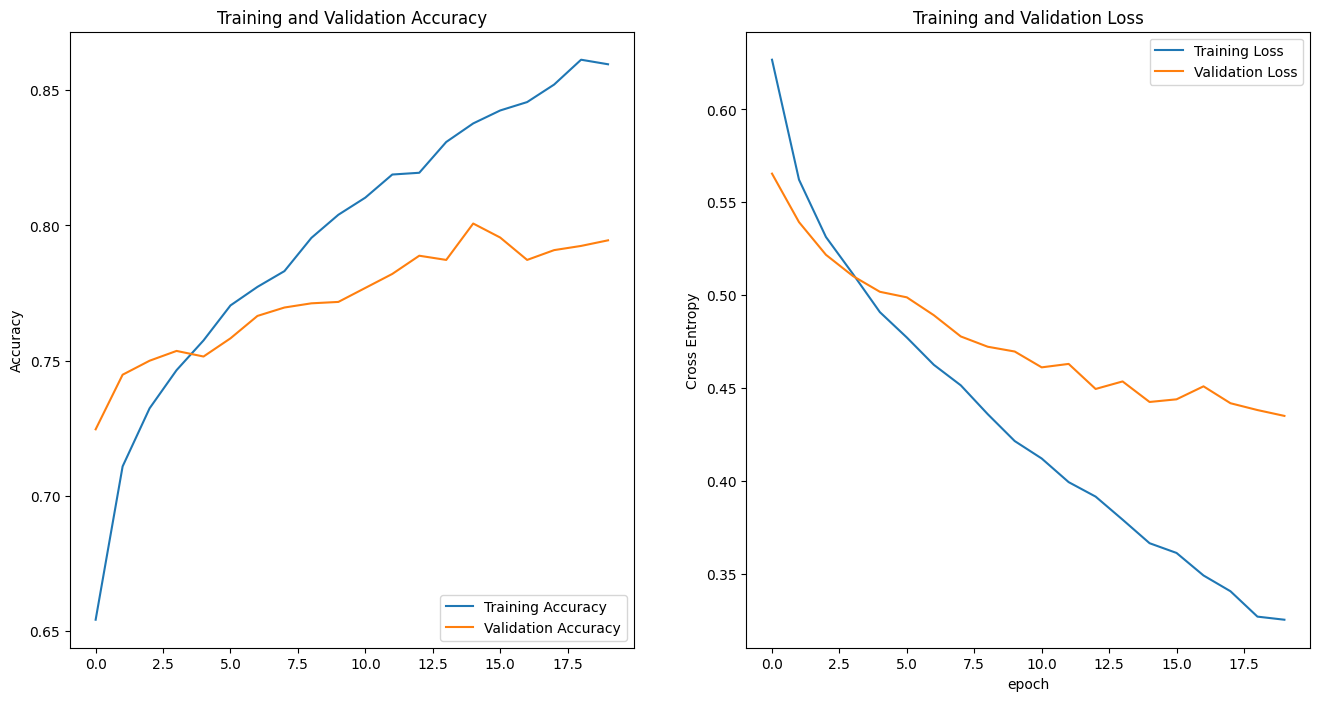

In [11]:
plot_history(history)

### What if we go deeper 👀?

In [12]:
filters = 32  # @param
kernel_size = [3, 3]  # @param
strides = 1 # @param
hidden_units = 128  # @param
dropout_rate = 0.2  # @param
learning_rate = 1e-4 # @param

deep_cnn_model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_height, img_width, 1)),
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),
  layers.Conv2D(filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Conv2D(2 * filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Conv2D(4 * filters, kernel_size, strides, padding='same', activation='relu'),
  layers.Conv2D(4 * filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Flatten(),
  layers.Dropout(rate=dropout_rate),
  layers.Dense(hidden_units, activation='relu'),
  layers.Dense(2)
], name="Deep-CNN")

deep_cnn_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate,  momentum=0.9),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

deep_cnn_model.summary()

Model: "Deep-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 48, 48, 1)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                      

In [13]:
history = deep_cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
242/242 [==============================] - 73s 295ms/step - loss: 0.6926 - accuracy: 0.5031 - val_loss: 0.6907 - val_accuracy: 0.5331
Epoch 2/20
242/242 [==============================] - 65s 267ms/step - loss: 0.6910 - accuracy: 0.5295 - val_loss: 0.6895 - val_accuracy: 0.5668
Epoch 3/20
242/242 [==============================] - 69s 286ms/step - loss: 0.6895 - accuracy: 0.5624 - val_loss: 0.6882 - val_accuracy: 0.5895
Epoch 4/20
242/242 [==============================] - 51s 212ms/step - loss: 0.6883 - accuracy: 0.5823 - val_loss: 0.6867 - val_accuracy: 0.5937
Epoch 5/20
242/242 [==============================] - 56s 231ms/step - loss: 0.6867 - accuracy: 0.5875 - val_loss: 0.6851 - val_accuracy: 0.5973
Epoch 6/20
242/242 [==============================] - 63s 261ms/step - loss: 0.6853 - accuracy: 0.5930 - val_loss: 0.6834 - val_accuracy: 0.6014
Epoch 7/20
242/242 [==============================] - 57s 234ms/step - loss: 0.6836 - accuracy: 0.5968 - val_loss: 0.6816 - val_ac

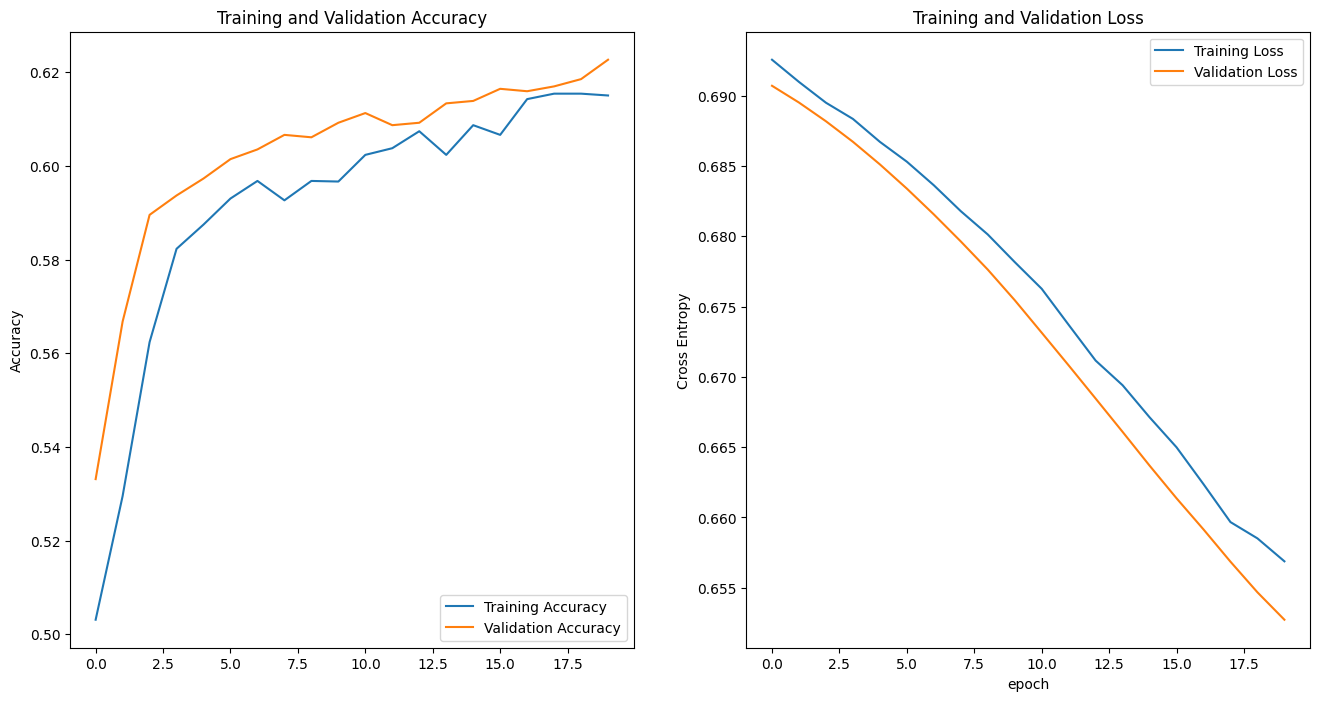

In [14]:
plot_history(history)

## Saving Models

To save models, all you need to do is `model.save`!

In [15]:
mlp_model.save('mlp_model.h5')

In [16]:
tf.keras.models.load_model('mlp_model.h5').summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 48, 48, 1)         0         
                                                                 
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               295040    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 2)                 258     